# Lab:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./demo2_mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



## Loading Tensorflow

Before starting this lab, you will need to install [Tensorflow](https://www.tensorflow.org/install/).  If you are using [Google colaboratory](https://colab.research.google.com), Tensorflow is already installed.  Run the following command to ensure Tensorflow is installed.

Then, load the other packages.

In [ ]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. In addition to `keras`, we will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install -u librosa
    
For Unix, you may need to load some additional packages:

    sudo apt-get install build-essential
    sudo apt-get install libxext-dev python-qt4 qt4-dev-tools
    pip install librosa
    
After you have installed the package, try to import it.

In [3]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [6]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO:  Load the file from url and save it in a file under the name fn

r = requests.get(url)  
with open('/Users/Rachana/Desktop/introml-master/unit09_neural/SopSax.Vib.pp.C6Eb6.aiff', 'wb') as file:
    file.write(r.content)

In [7]:
# TODO
# y, sr = ...
y, sr = librosa.load(fn)

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

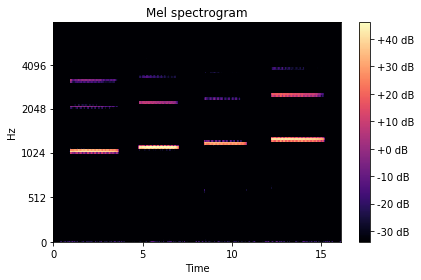

In [8]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, the segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [9]:
data_dir = 'instrument_dataset/'
xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class?


In [10]:
# TODO
xtr.shape

(66247, 120)

In [11]:
xts.shape

(14904, 120)

In [12]:
nc = np.unique(ytr)
print('Number of instruments per class: ', len(nc))

Number of instruments per class:  10


In [13]:
n_tr = xtr.shape[0]
n_ts = xts.shape[0]
nfeature = xtr.shape[1]
print('Number of training samples are: ', n_tr)
print('Number of test samples are: ', n_ts)
print('Number of features for each samples are: ', nfeature)

Number of training samples are:  66247
Number of test samples are:  14904
Number of features for each samples are:  120


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [14]:

xtr_scale = [n_tr,nfeature]
xts_scale = [n_ts,nfeature]

xtr_mean = np.mean(xtr, axis=0)
xtr_std = np.std(xtr, axis=0)
xtr_scale = (xtr - xtr_mean[None,:])/xtr_std[None,:]

xts_mean = np.mean(xts, axis=0)
xts_std = np.std(xts, axis=0)
xts_scale = (xts - xts_mean[None,:])/xts_std[None,:]


## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb), clear the keras session.  Then, create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation
* select the input and output shapes correctly
* print the model summary

In [15]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.backend as K


In [16]:
# TODO clear session
K.clear_session()

In [17]:
# TODO: construct the model
n_in = Xtr.shape[1]  # dimension of input data
nh = 256     # number of hidden units
nout = int(np.max(ytr)+1)    # number of outputs = 10 since there are 10 classes
model = Sequential()
model.add(Dense(nh, input_shape=(n_in,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))

W0409 22:27:46.901653 4603262400 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
# TODO:  Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


Create an optimizer and compile the model.  Select the appropriate loss function and metrics.  For the optimizer, use the Adam optimizer with a learning rate of 0.001

In [21]:

from tensorflow.keras import optimizers
opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Fit the model for 10 epochs using the scaled data for both the training and validation.  Use the `validation_data` option to pass the test data.  Also, pass the callback class create above.  Use a batch size of 100.  Your final accuracy should be >99%.

In [22]:
# TODO
hist = model.fit(xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(xts_scale,yts))

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 2s 34us/sample - loss: 0.3622 - acc: 0.9010 - val_loss: 0.1889 - val_acc: 0.9516
Epoch 2/10
66247/66247 [==============================] - 2s 36us/sample - loss: 0.1024 - acc: 0.9762 - val_loss: 0.1402 - val_acc: 0.9530
Epoch 3/10
66247/66247 [==============================] - 2s 32us/sample - loss: 0.0605 - acc: 0.9854 - val_loss: 0.1220 - val_acc: 0.9546
Epoch 4/10
66247/66247 [==============================] - 2s 25us/sample - loss: 0.0421 - acc: 0.9897 - val_loss: 0.1049 - val_acc: 0.9621
Epoch 5/10
66247/66247 [==============================] - 2s 31us/sample - loss: 0.0323 - acc: 0.9916 - val_loss: 0.1248 - val_acc: 0.9510
Epoch 6/10
66247/66247 [==============================] - 2s 30us/sample - loss: 0.0253 - acc: 0.9935 - val_loss: 0.1021 - val_acc: 0.9630
Epoch 7/10
66247/66247 [==============================] - 2s 25us/sample - loss: 0.0209 - acc: 0.9948 - val_loss: 0.

Plot the validation accuracy saved in `hist.history` dictionary. This gives one accuracy value per epoch.  You should see that the validation accuracy saturates at a little higher than 99%.  After that it "bounces around" due to the noise in the stochastic gradient descent.

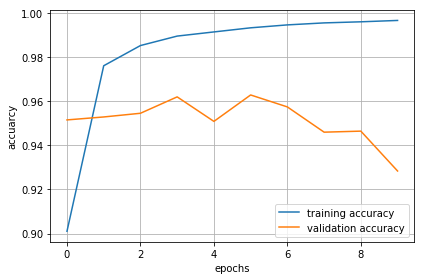

In [25]:
# TODO
tr_accuracy = hist.history['acc']
val_accuracy = hist.history['val_acc']
loss_epoch = hist.history['loss']
val_loss_epoch = hist.history['val_loss']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.tight_layout()
plt.show()

Plot the loss values saved in the `hist.history` dictionary.  You should see that the loss is steadily decreasing.  Use the `semilogy` plot.

Text(0,0.5,'loss')

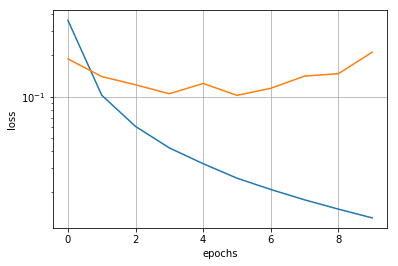

In [26]:
# TODO
plt.semilogy(loss_epoch)
plt.semilogy(val_loss_epoch)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')


## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying four learning rates as shown in the vector `rates`.  For each learning rate:
* clear the session
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model for 20 epochs
* save the accuracy and losses

In [27]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
train_acc = []
validation_acc = []

n = len(rates)
for i in range(n):
    #clear the session
    K.clear_session()
    #construct the network
    n_in = xtr.shape[1]  # dimension of input data
    nh = 256     # number of hidden units
    nout = int(np.max(ytr)+1)    # number of outputs = 10 since there are 10 classes
    model = Sequential()
    model.add(Dense(nh, input_shape=(n_in,), activation='sigmoid', name='hidden'))
    model.add(Dense(nout, activation='softmax', name='output'))
    #select the optimizer
    opt = optimizers.Adam(lr=rates[i]) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    #train the model
    hist_i = model.fit(xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(xts_scale,yts))
    #save accuracy and losses
    tr_accuracy = hist_i.history['acc']
    val_accuracy = hist_i.history['val_acc']
    loss_epoch = hist_i.history['loss']
    loss_hist.append(loss_epoch)
    train_acc.append(tr_accuracy)
    validation_acc.append(val_accuracy)

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 2s 23us/sample - loss: 0.1043 - acc: 0.9679 - val_loss: 0.0971 - val_acc: 0.9678
Epoch 2/10
66247/66247 [==============================] - 2s 24us/sample - loss: 0.0273 - acc: 0.9914 - val_loss: 0.2668 - val_acc: 0.9166
Epoch 3/10
66247/66247 [==============================] - 1s 21us/sample - loss: 0.0205 - acc: 0.9936 - val_loss: 0.2272 - val_acc: 0.9373
Epoch 4/10
66247/66247 [==============================] - 1s 21us/sample - loss: 0.0192 - acc: 0.9937 - val_loss: 0.3287 - val_acc: 0.9264
Epoch 5/10
66247/66247 [==============================] - 1s 22us/sample - loss: 0.0161 - acc: 0.9945 - val_loss: 0.3537 - val_acc: 0.9246
Epoch 6/10
66247/66247 [==============================] - 2s 25us/sample - loss: 0.0120 - acc: 0.9962 - val_loss: 0.4904 - val_acc: 0.9114
Epoch 7/10
66247/66247 [==============================] - 2s 23us/sample - loss: 0.0143 - acc: 0.9955 - val_loss: 0.

Text(0,0.5,'loss')

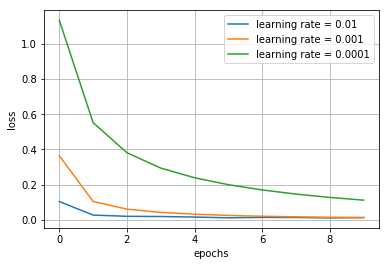

In [29]:
for i in range(n):
    plt.plot(loss_hist[i])
    
plt.legend(['learning rate = 0.01', 'learning rate = 0.001','learning rate = 0.0001'])
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
